<a href="https://colab.research.google.com/github/sungkim11/forecast-sales/blob/main/forecast_sales_using_prophet_regressors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast Sales Using Prophet with Regressors

## 1. Prequisites

Following are prerequisite software for this tutorial:

- Data
- Python Package: fbprophet or Facebook Prophet

### 1.1. Data

Three data sources were used for this tutorial where United Stated Census Bureau Monthly Retail Sales is used to forecast future sales and both FRED Data and OECD Data were used as Regressors data.

**United Stated Census Bureau Monthly Retail Sales**<BR>
United Stated Census Bureau maintains Monthly Retail Trade Report, from January 1992 to Present. This data was picked to illustrate forecasting because it has extensive historical data with same monthly frequency. Data is available as Excel spreadsheet format at https://www.census.gov/retail/mrts/www/mrtssales92-present.xls

**FRED Data: https://fred.stlouisfed.org/**
- Inflation
- CPI
- M1
- M2
- Interest Rate

**OECD Data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart**
- Composite leading indicator (CLI)
- Business confidence index (BCI)
- Consumer confidence index (CCI)

### 1.2. Python Packages

#### 1.2.1. Install Prophet

**Please note that you only need to run install once.**

In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip install fbprophet

## 2. Code

#### 2.1. Import Python Package

Import python packages so python can use them and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [185]:
import pandas as pd
import matplotlib as plt
import fbprophet
from fbprophet import Prophet
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import platform

from pandas.tseries.offsets import MonthBegin
from pandas.tseries.offsets import MonthEnd

from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

In [2]:
print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('Prophet: ', fbprophet.__version__)
print('statsmodels: ', statsmodels.__version__)

Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.2.2
Prophet:  0.7.1
statsmodels:  0.10.2


#### 2.1. Mount Storage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3. Exploratory Data Analysis

#### Import and validate dataset

In [163]:
retail_sales_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecast-sales/data/mrtssales92-present-regressors.csv', index_col = 0)
retail_sales_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1/1/2005 to 1/1/2022
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales_total     205 non-null    int64  
 1   inflation_rate  205 non-null    float64
 2   cpi             205 non-null    float64
 3   m1              205 non-null    float64
 4   m2              205 non-null    float64
 5   cli             205 non-null    float64
 6   bci             205 non-null    float64
 7   cci             205 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 14.4+ KB


In [164]:
retail_sales_all.head(5)

,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci
month,,,,,,,,
1/1/2005,293261,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
2/1/2005,295062,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
3/1/2005,339141,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
4/1/2005,335632,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
5/1/2005,345348,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


#### Convert month date to month-end because of fbprophet's use of month-end date.

In [165]:
retail_sales_all.reset_index(inplace = True)
retail_sales_all['month'] = pd.to_datetime(retail_sales_all['month']) + MonthEnd(1)
retail_sales_all.set_index(['month'], inplace = True)
retail_sales_all.index = pd.to_datetime(retail_sales_all.index)
retail_sales_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2005-01-31 to 2022-01-31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales_total     205 non-null    int64  
 1   inflation_rate  205 non-null    float64
 2   cpi             205 non-null    float64
 3   m1              205 non-null    float64
 4   m2              205 non-null    float64
 5   cli             205 non-null    float64
 6   bci             205 non-null    float64
 7   cci             205 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 14.4 KB


In [166]:
retail_sales_all.head(5)

,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci
month,,,,,,,,
2005-01-31,293261,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
2005-02-28,295062,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2005-03-31,339141,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
2005-04-30,335632,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
2005-05-31,345348,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


#### Slice Datasets

Slice datasets to sales data and regressor data:
- Sales Data: Date and Sales Total
- Regressors: inflation rate, cpi, m1, m2, cli, bci, and cci

In [167]:
retail_sales = retail_sales_all.filter(["month","sales_total"])
retail_sales.head()

,sales_total
month,
2005-01-31,293261
2005-02-28,295062
2005-03-31,339141
2005-04-30,335632
2005-05-31,345348


In [168]:
retail_sales_regressors = retail_sales_all.filter(["month", "inflation_rate", "cpi", "m1", "m2", "cli", "bci", "cci"])
retail_sales_regressors.head()

,inflation_rate,cpi,m1,m2,cli,bci,cci
month,,,,,,,
2005-01-31,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
2005-02-28,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2005-03-31,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
2005-04-30,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
2005-05-31,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


#### Split Datasets

Split datasets:
- Actuals
- Train
- Test
- Validate
- Cross Validate

In [169]:
retail_sales_actuals = retail_sales.loc['2005-01-01':'2018-12-31']
retail_sales_train = retail_sales.loc['2005-01-01':'2016-12-31']
retail_sales_test = retail_sales.loc['2017-01-01':'2018-12-31']
retail_sales_traintest = retail_sales.loc['2005-01-01':'2018-12-31']
retail_sales_validate = retail_sales.loc['2019-01-01':'2021-12-31']
retail_sales_cross_validate = retail_sales.loc['2017-01-01':'2021-12-31']

print('Actuals: ', retail_sales_actuals.shape)
print('Train: ', retail_sales_train.shape)
print('Test: ', retail_sales_test.shape)
print('Train and Test: ', retail_sales_traintest.shape)
print('Validate: ', retail_sales_validate.shape)
print('Cross Validate: ', retail_sales_cross_validate.shape)

Actuals:  (168, 1)
Train:  (144, 1)
Test:  (24, 1)
Train and Test:  (168, 1)
Validate:  (36, 1)
Cross Validate:  (60, 1)


#### Set Plotting Parameters

In [170]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#### Chart Retail Sales

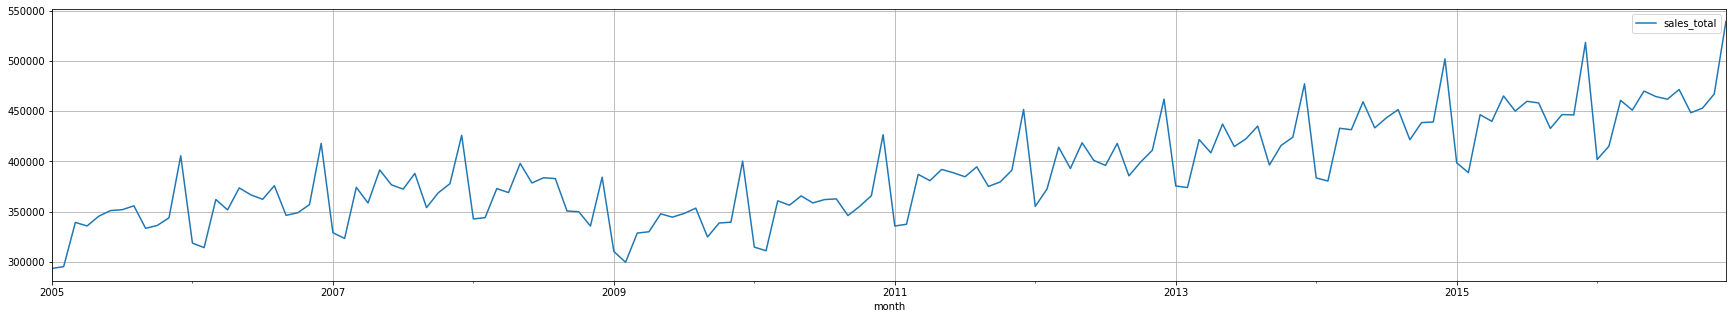

In [171]:
retail_sales_train.reset_index().plot(x='month', y='sales_total', kind='line', grid=1)
plt.pyplot.show()

#### Decompose Retail Sales

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

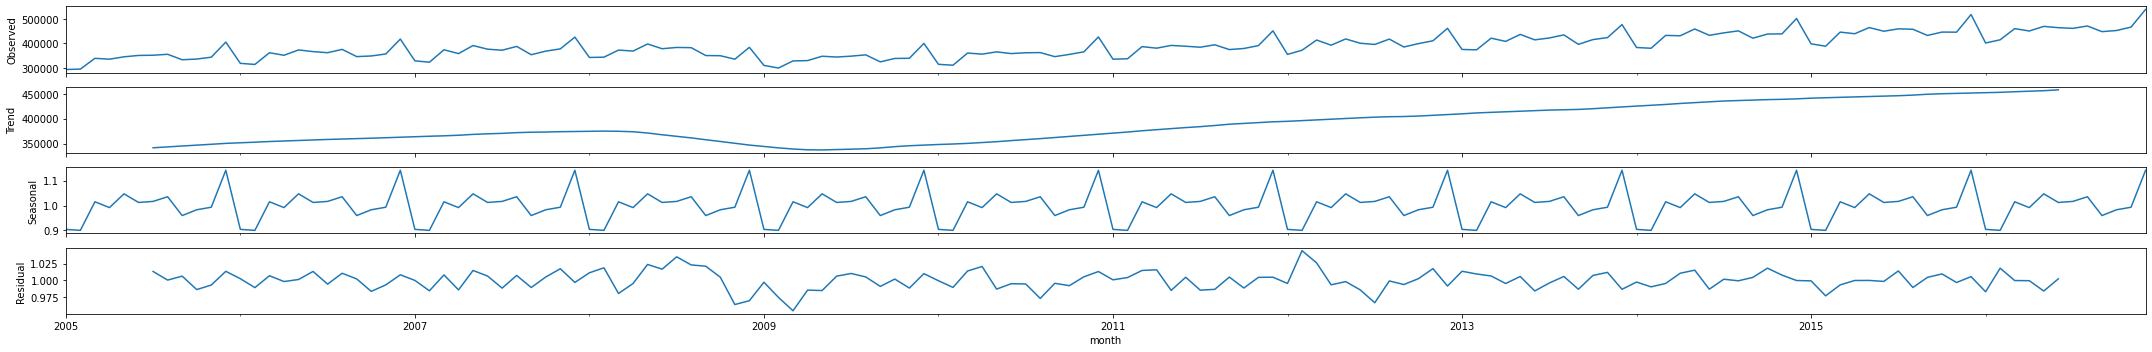

In [172]:
retail_sales_train.index = pd.to_datetime(retail_sales_train.index)
retail_sales_train_decompose_result = seasonal_decompose(retail_sales_train, model='multiplicative')
retail_sales_train_decompose_result.plot()
plt.pyplot.show()

#### Prep Train Dataset

In [173]:
retail_sales_regressors = retail_sales_regressors.reset_index()
retail_sales_train = retail_sales_train.merge(retail_sales_regressors, on='month', how='left')
retail_sales_train.head()

,month,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci
0,2005-01-31,293261,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
1,2005-02-28,295062,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2,2005-03-31,339141,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
3,2005-04-30,335632,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
4,2005-05-31,345348,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


In [174]:
retail_sales_train.columns = ['ds', 'y', 'inflation', 'cpi', 'm1', 'm2', 'cli', 'bci', 'cci']
retail_sales_train.head()

,ds,y,inflation,cpi,m1,m2,cli,bci,cci
0,2005-01-31,293261,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
1,2005-02-28,295062,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2,2005-03-31,339141,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
3,2005-04-30,335632,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
4,2005-05-31,345348,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


####Develop and Fit Forecast Model then Forecast Sales (for Test) using Forecast Model

In [208]:
retail_sales_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
retail_sales_model.add_regressor('inflation')
#retail_sales_model.add_regressor('cpi')
#retail_sales_model.add_regressor('m1')
#retail_sales_model.add_regressor('m2')
#retail_sales_model.add_regressor('cli')
#retail_sales_model.add_regressor('bci')
#retail_sales_model.add_regressor('cci')
retail_sales_model.fit(retail_sales_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [209]:
retail_sales_future = retail_sales_model.make_future_dataframe(freq='M', periods=24)
retail_sales_future.head(5)

,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31


In [210]:
retail_sales_regressors.columns = ['ds', 'inflation', 'cpi', 'm1', 'm2', 'cli', 'bci', 'cci']
retail_sales_future = retail_sales_future.merge(retail_sales_regressors, on='ds', how='left')
retail_sales_future.tail(5)

,ds,inflation,cpi,m1,m2,cli,bci,cci
163,2018-08-31,2.13,258.028,3664.825,14179.0,99.08091,99.29861,101.1488
164,2018-09-30,2.08,258.505,3678.425,14217.2,98.69699,99.12753,101.0597
165,2018-10-31,2.14,258.997,3727.380,14218.7,98.31645,98.99612,100.9435
166,2018-11-30,2.02,259.455,3664.175,14260.9,97.96261,98.88857,100.8148
167,2018-12-31,1.97,259.934,3814.200,14452.3,97.66416,98.78981,100.7151


In [211]:
retail_sales_forecast = retail_sales_model.predict(retail_sales_future)
retail_sales_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,inflation,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
163,2018-08-31,505735.438662,508534.406310,532246.591633,496213.887528,515372.891444,0.001314,0.001314,0.001314,0.001314,...,0.028923,0.028923,0.028923,0.027609,0.027609,0.027609,0.0,0.0,0.0,520362.942856
164,2018-09-30,507159.074678,474630.850227,498932.362452,497011.208637,517468.681083,-0.000425,-0.000425,-0.000425,-0.000425,...,-0.039502,-0.039502,-0.039502,-0.039077,-0.039077,-0.039077,0.0,0.0,0.0,487125.272603
165,2018-10-31,508630.165228,490060.747275,515114.877948,497895.173712,519664.545053,0.001662,0.001662,0.001662,0.001662,...,-0.012144,-0.012144,-0.012144,-0.013806,-0.013806,-0.013806,0.0,0.0,0.0,502453.156457
166,2018-11-30,510053.801245,492811.214379,520631.115427,498552.587825,521714.870874,-0.002512,-0.002512,-0.002512,-0.002512,...,-0.006551,-0.006551,-0.006551,-0.004039,-0.004039,-0.004039,0.0,0.0,0.0,506712.245650
167,2018-12-31,511524.891795,568008.055722,599957.613924,499273.409987,524055.308970,-0.004252,-0.004252,-0.004252,-0.004252,...,0.141271,0.141271,0.141271,0.145523,0.145523,0.145523,0.0,0.0,0.0,583788.599280


####Chart Sales Forecast

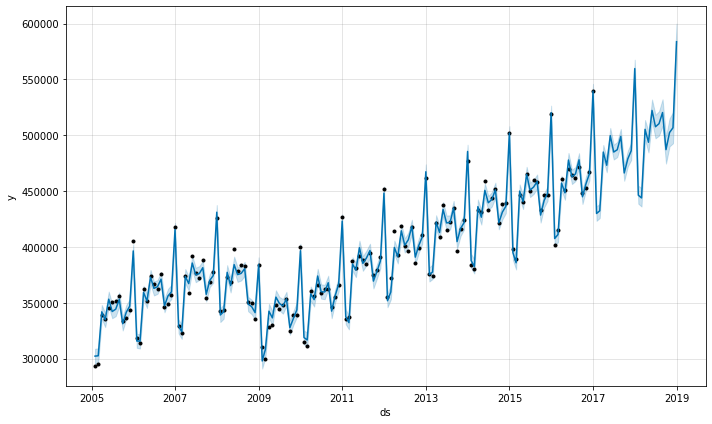

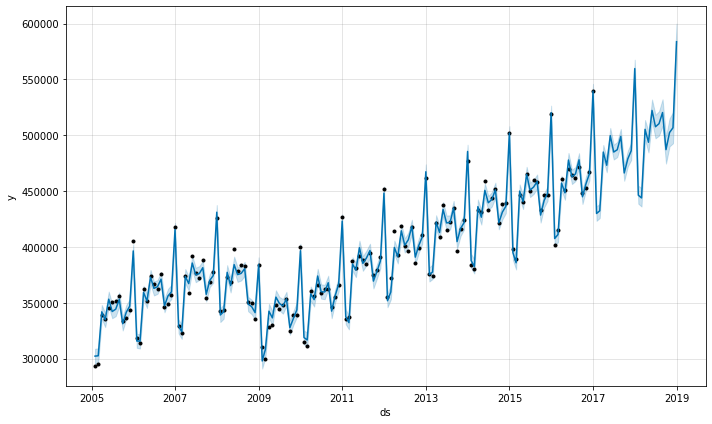

In [212]:
retail_sales_model.plot(retail_sales_forecast)

####Chart Sales Forecast Components

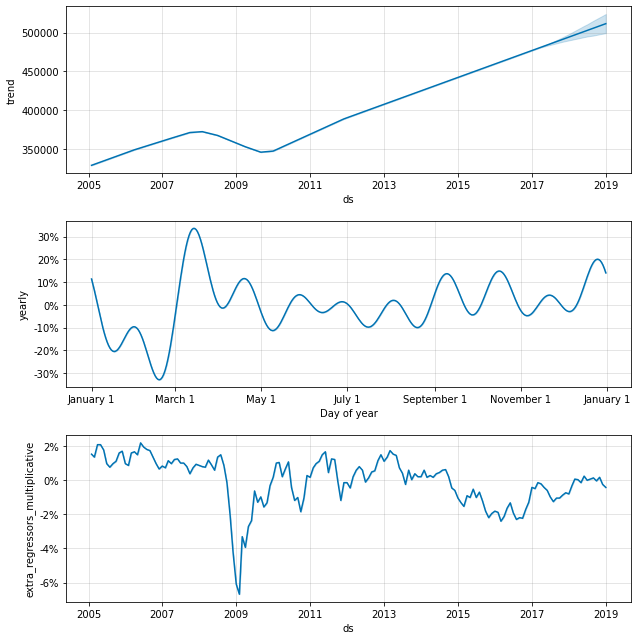

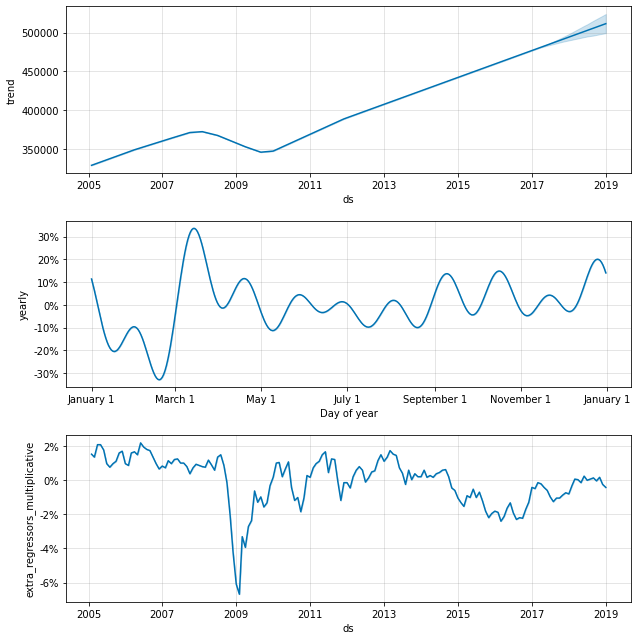

In [213]:
retail_sales_model.plot_components(retail_sales_forecast)

####Validate Sales Forecast - Prophet Validation Method

In [214]:
retail_sales_cv = cross_validation(retail_sales_model, initial = '1825 days', period='365 days', horizon=' 2190 days', parallel='processes')
retail_sales_cv.tail(5)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-01-02 00:00:00 and 2011-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f73840bfbd0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
67,2016-08-31,479114.310880,347397.360207,603748.656748,471690,2011-01-02
68,2016-09-30,447947.447495,322014.958271,566410.420039,448516,2011-01-02
69,2016-10-31,459046.212808,329621.902938,582799.851210,453155,2011-01-02
70,2016-11-30,457763.940154,324620.481955,583286.799868,467232,2011-01-02
71,2016-12-31,547387.280444,385404.258184,703628.628908,539667,2011-01-02


In [215]:
retail_sales_p = performance_metrics(retail_sales_cv)
retail_sales_p.tail(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
61,2068 days,7.431722e+07,8620.743472,7411.943659,0.016163,0.015740,1.0
62,2098 days,6.940267e+07,8330.826482,6651.336909,0.014316,0.015740,1.0
63,2129 days,5.579078e+07,7469.322771,5864.181864,0.012639,0.013000,1.0
64,2159 days,6.838941e+07,8269.789140,7044.516823,0.015152,0.015740,1.0
65,2190 days,6.286088e+07,7928.485623,6731.020022,0.014183,0.014306,1.0


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


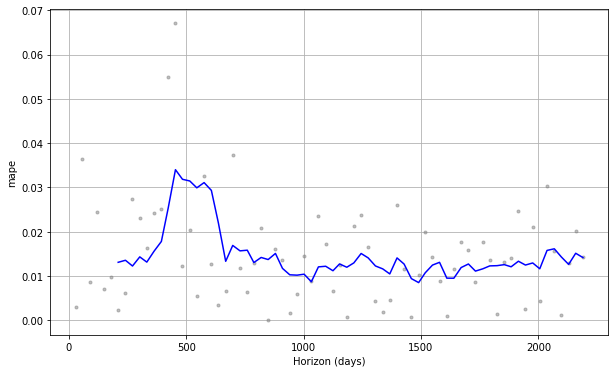

In [216]:
fig = plot_cross_validation_metric(retail_sales_cv, metric='mape')

In [217]:
retail_sales_p.mean()

horizon     1199 days 18:10:54.545454544
mse                      62297170.924685
rmse                         7426.662465
mae                          6195.193345
mape                            0.014799
mdape                           0.013618
coverage                        0.911255
dtype: object

####Validate Sales Forecast - Forecast All Methods

In [221]:
retail_sales_forecast_filtered = retail_sales_forecast.filter(["ds","yhat"])
retail_sales_forecast_filtered.head(5)

,ds,yhat
0,2005-01-31,302204.816581
1,2005-02-28,302518.829413
2,2005-03-31,341860.527503
3,2005-04-30,334869.867685
4,2005-05-31,353195.514076


In [222]:
retail_sales_forecast_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_filtered = retail_sales_forecast_filtered.set_index('Month')
retail_sales_validate = pd.DataFrame(retail_sales_forecast_filtered, index =retail_sales_test.index, columns=['Prediction'])
retail_sales_validate = pd.concat([retail_sales_test, retail_sales_validate], axis=1)
retail_sales_validate.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,429953.586051
2017-02-28,418315,432340.486632
2017-03-31,483082,484949.136652
2017-04-30,465788,473130.055892
2017-05-31,494621,499632.229278


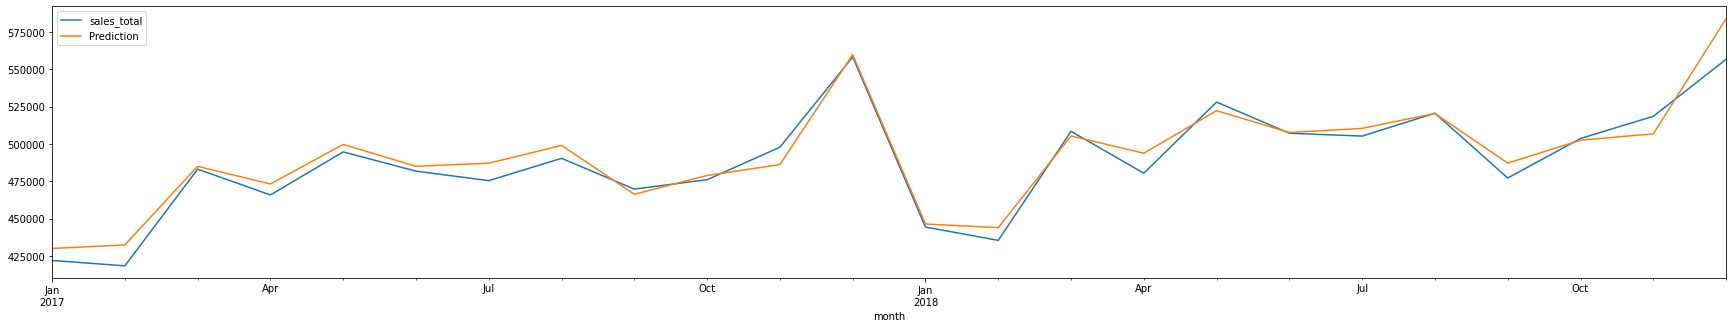

In [223]:
retail_sales_validate.plot()
plt.pyplot.show()

In [224]:
retail_sales_validate['Abs Diff'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()
retail_sales_validate['Abs Diff %'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()/retail_sales_validate['sales_total']
retail_sales_validate.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate.tail(10)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2018-06-30 00:00:00,507106.0,507621.874343,515.874343,0.001017
2018-07-31 00:00:00,505209.0,510367.353442,5158.353442,0.010210
2018-08-31 00:00:00,520544.0,520362.942856,181.057144,0.000348
2018-09-30 00:00:00,477137.0,487125.272603,9988.272603,0.020934
2018-10-31 00:00:00,503602.0,502453.156457,1148.843543,0.002281
2018-11-30 00:00:00,518457.0,506712.245650,11744.754350,0.022653
2018-12-31 00:00:00,556614.0,583788.599280,27174.599280,0.048821
Average Abs Diff %,NaN,NaN,NaN,0.014400
Min Abs Diff %,NaN,NaN,NaN,0.000348


####Forecast Sales All using same Forecast Model

Using same forecast model, forecast sales for all months till Deceomber 2021.

In [225]:
retail_sales_future_all = retail_sales_model.make_future_dataframe(freq='M', periods=60)

In [226]:
retail_sales_future_all = retail_sales_future_all.merge(retail_sales_regressors, on='ds', how='left')
retail_sales_future_all.head(5)

,ds,inflation,cpi,m1,m2,cli,bci,cci
0,2005-01-31,2.53,199.0,1374.700,6406.1,100.2392,103.5195,101.0167
1,2005-02-28,2.48,199.4,1355.000,6404.6,100.2278,103.3132,100.9915
2,2005-03-31,2.69,200.1,1374.675,6462.9,100.1927,103.1299,100.8536
3,2005-04-30,2.69,200.2,1370.775,6517.4,100.1402,103.0560,100.7005
4,2005-05-31,2.60,200.5,1373.980,6453.0,100.0809,103.0645,100.6352


In [227]:
retail_sales_forecast_all = retail_sales_model.predict(retail_sales_future_all)
retail_sales_forecast_all.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,inflation,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
199,2021-08-31,557745.607789,533721.082875,631744.063639,512026.846077,605944.503227,0.010707,0.010707,0.010707,0.010707,...,0.042838,0.042838,0.042838,0.032132,0.032132,0.032132,0.0,0.0,0.0,581638.319562
200,2021-09-30,559169.243805,497247.613019,590561.979390,511970.614310,608826.804469,0.008619,0.008619,0.008619,0.008619,...,-0.029039,-0.029039,-0.029039,-0.037658,-0.037658,-0.037658,0.0,0.0,0.0,542931.550032
201,2021-10-31,560640.334355,508325.402932,606049.982179,512433.774527,611499.316278,0.010011,0.010011,0.010011,0.010011,...,-0.006647,-0.006647,-0.006647,-0.016658,-0.016658,-0.016658,0.0,0.0,0.0,556913.561818
202,2021-11-30,562063.970371,515962.846264,618565.646750,512594.839454,614074.208516,0.014185,0.014185,0.014185,0.014185,...,0.008247,0.008247,0.008247,-0.005938,-0.005938,-0.005938,0.0,0.0,0.0,566699.497631
203,2021-12-31,563535.060921,589924.749344,712270.979833,512581.391404,616738.456218,0.012098,0.012098,0.012098,0.012098,...,0.152725,0.152725,0.152725,0.140627,0.140627,0.140627,0.0,0.0,0.0,649600.981238


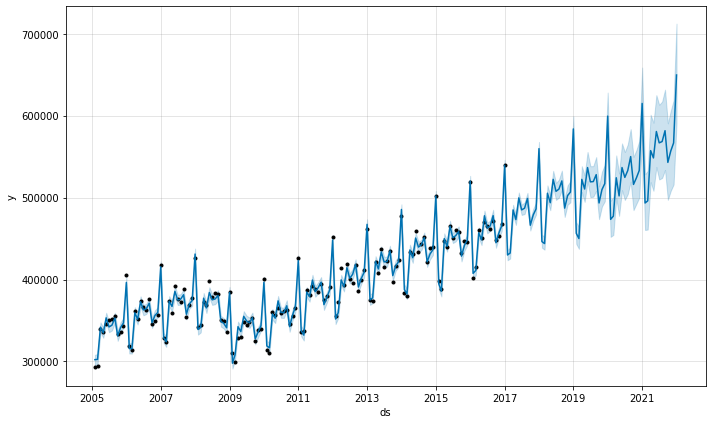

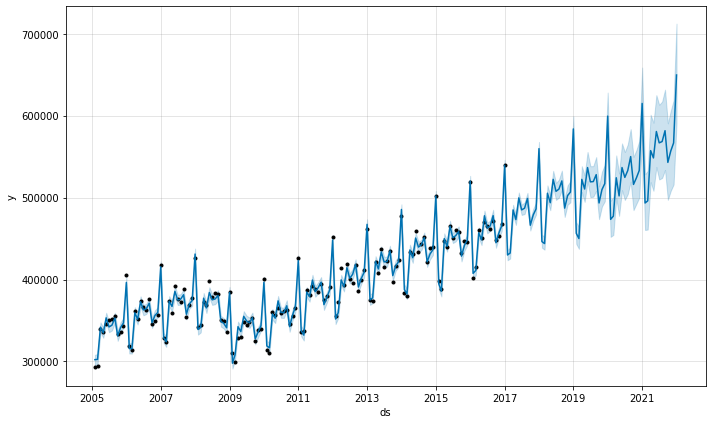

In [228]:
retail_sales_model.plot(retail_sales_forecast_all)

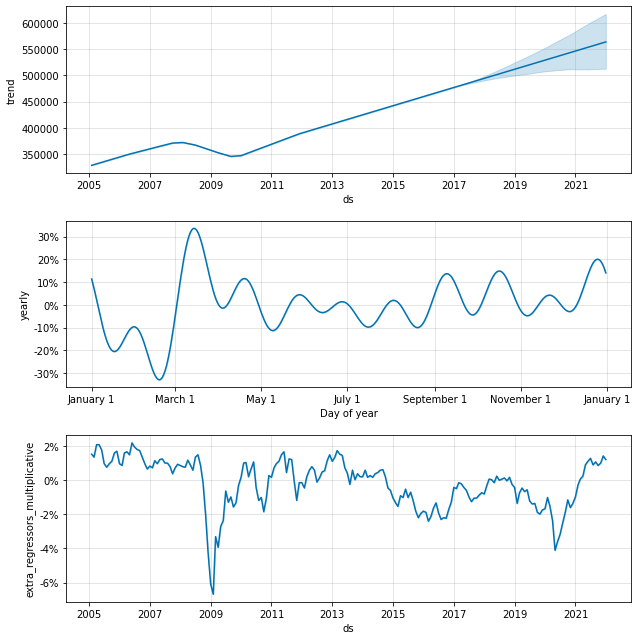

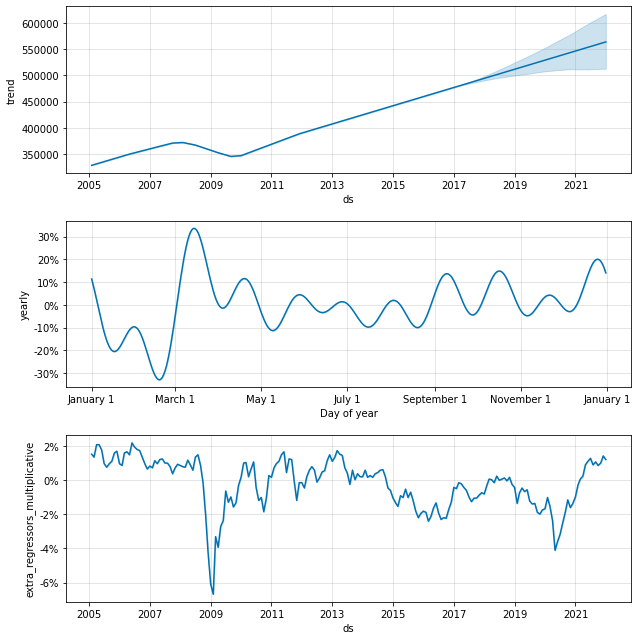

In [229]:
retail_sales_model.plot_components(retail_sales_forecast_all)

####Validate Sales All Forecast - All Forecast Methodology

Please note that forecast will not perform well for both calendar year 2020 and 2021.

In [230]:
retail_sales_forecast_all_filtered = retail_sales_forecast_all.filter(["ds","yhat"])
retail_sales_forecast_all_filtered.head(5)

,ds,yhat
0,2005-01-31,302204.816581
1,2005-02-28,302518.829413
2,2005-03-31,341860.527503
3,2005-04-30,334869.867685
4,2005-05-31,353195.514076


In [231]:
retail_sales_forecast_all_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_all_filtered = retail_sales_forecast_all_filtered.set_index('Month')

retail_sales_validate_all = pd.DataFrame(retail_sales_forecast_all_filtered, index =retail_sales_cross_validate.index, columns=['Prediction'])
retail_sales_validate_all = pd.concat([retail_sales_cross_validate, retail_sales_validate_all], axis=1)
retail_sales_validate_all.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,429953.586051
2017-02-28,418315,432340.486632
2017-03-31,483082,484949.136652
2017-04-30,465788,473130.055892
2017-05-31,494621,499632.229278


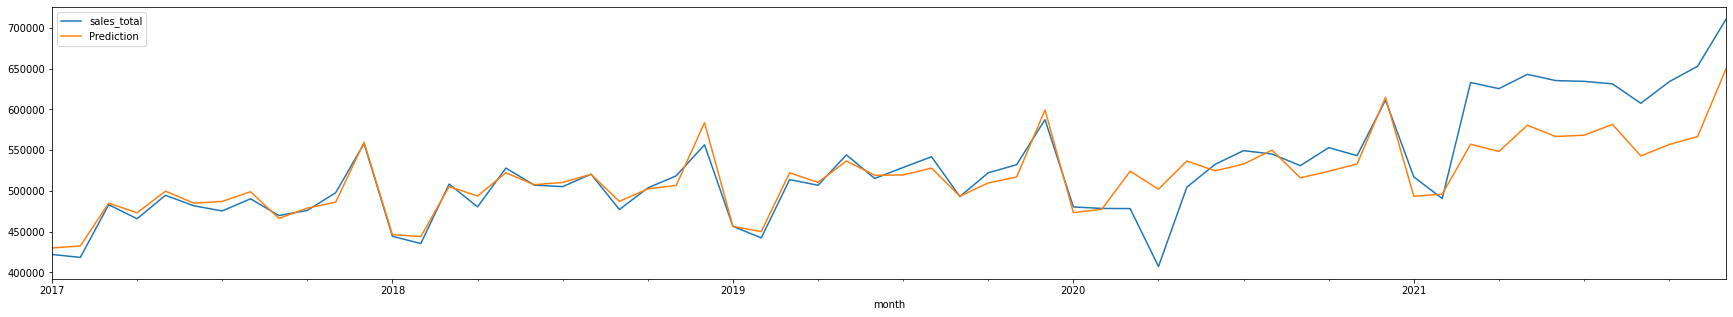

In [232]:
retail_sales_validate_all.plot()
plt.pyplot.show()

In [233]:
retail_sales_validate_all['Abs Diff'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()
retail_sales_validate_all['Abs Diff %'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()/retail_sales_validate_all['sales_total']
retail_sales_validate_all.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate_all.tail(10)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2021-06-30 00:00:00,635437.0,566783.415085,68653.584915,0.108042
2021-07-31 00:00:00,634486.0,568378.450468,66107.549532,0.104191
2021-08-31 00:00:00,631415.0,581638.319562,49776.680438,0.078834
2021-09-30 00:00:00,607540.0,542931.550032,64608.449968,0.106344
2021-10-31 00:00:00,634076.0,556913.561818,77162.438182,0.121693
2021-11-30 00:00:00,653011.0,566699.497631,86311.502369,0.132175
2021-12-31 00:00:00,710619.0,649600.981238,61018.018762,0.085866
Average Abs Diff %,NaN,NaN,NaN,0.037106
Min Abs Diff %,NaN,NaN,NaN,0.000278
